# Use MACS3 API to call peaks for each cluster in PBMC 10k scATAC-seq data

The scATAC-seq data was downloaded from [10X genomics website](https://www.10xgenomics.com/datasets/10k-human-pbmcs-atac-v2-chromium-x-2-standard). The files used in this tutorial are:
- [Clustering analysis](https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_X/10k_pbmc_ATACv2_nextgem_Chromium_X_analysis.tar.gz) for the clustering results
- [Fragments](https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_X/10k_pbmc_ATACv2_nextgem_Chromium_X_fragments.tsv.gz) for the locations of aligned fragments in TSV format
- [Per Barcode Metrics](https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_X/10k_pbmc_ATACv2_nextgem_Chromium_X_singlecell.csv) for the information of each barcode

## Load the fragment file and build pileup track

We will import the fragment file parser from MACS3.

In [1]:
# %pip install macs3 panda

from MACS3.IO.Parser import FragParser
from MACS3.IO.BedGraphIO import bedGraphIO
from MACS3.Utilities.Logger import logging

# we can use the pre-configured logging function from MACS3 to monitor memory usage...
logger = logging.getLogger("demo")
info = logger.info
# Note, you can replace `print` with `info` to show the time and memory usage at that moment.


The fragment file is `10k_pbmc_ATACv2_nextgem_Chromium_X_fragments.tsv.gz`. Note that MACS3 can directly load gzipped files. We will load the file and build a `PairEndTrack.PETrackII` object, which contains alignment locations, barcodes and counts.

In [2]:
frag_file = FragParser("./10k_pbmc_ATACv2_nextgem_Chromium_X_fragments.tsv.gz", buffer_size=100000)
petrack = frag_file.build_petrack(max_count=2)
petrack.finalize()

INFO  @ 20 Nov 2025 11:47:51: [192 MB]  1000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:52: [217 MB]  2000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:53: [233 MB]  3000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:53: [255 MB]  4000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:54: [283 MB]  5000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:55: [310 MB]  6000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:55: [310 MB]  7000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:56: [310 MB]  8000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:57: [326 MB]  9000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:57: [341 MB]  10000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:58: [358 MB]  11000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:58: [368 MB]  12000000 fragments parsed 
INFO  @ 20 Nov 2025 11:47:59: [368 MB]  13000000 fragments parsed 
INFO  @ 20 Nov 2025 11:48:00: [368 MB]  14000000 fragments parsed 
INFO  @ 20 Nov 2025 11:48:00: [368 MB]  15000000 fragments parsed 
INFO

Before we call peaks, let's clean up the data by removing uncommon chromosomes from downstream analysis. Let's check first...

In [3]:
petrack_rlengths = petrack.rlengths
print(list(petrack_rlengths.keys()))

[b'GL000009.2', b'GL000194.1', b'GL000195.1', b'GL000205.2', b'GL000213.1', b'GL000218.1', b'GL000219.1', b'KI270711.1', b'KI270713.1', b'KI270721.1', b'KI270726.1', b'KI270727.1', b'KI270728.1', b'KI270731.1', b'KI270734.1', b'chr1', b'chr10', b'chr11', b'chr12', b'chr13', b'chr14', b'chr15', b'chr16', b'chr17', b'chr18', b'chr19', b'chr2', b'chr20', b'chr21', b'chr22', b'chr3', b'chr4', b'chr5', b'chr6', b'chr7', b'chr8', b'chr9', b'chrX', b'chrY']


Let's only keep chr1 to chrY. In order to do so, we need to construct genomic 'regions' covering the uncommon chromosomes, and then 'exclude' any fragments overlapping with those regions.

In [4]:
%%time
from MACS3.Signal.Region import Regions

regions_to_be_excluded = Regions()
for chrom, chrom_length in petrack_rlengths.items():
    if not chrom.startswith(b'chr'): # this rule may not work if you want to exclude chomosome such as chr1_random, so adjust it if it's necessary
        regions_to_be_excluded.add_loc(chrom, 0, chrom_length)

# then use .exclude of PETrackII 
petrack.exclude(regions_to_be_excluded)
petrack.finalize()

CPU times: user 5min 57s, sys: 1.68 s, total: 5min 59s
Wall time: 5min 58s


Now check the chromosome names again.

In [5]:
petrack_rlengths = petrack.rlengths
print(list(petrack_rlengths.keys()))

[b'chr1', b'chr10', b'chr11', b'chr12', b'chr13', b'chr14', b'chr15', b'chr16', b'chr17', b'chr18', b'chr19', b'chr2', b'chr20', b'chr21', b'chr22', b'chr3', b'chr4', b'chr5', b'chr6', b'chr7', b'chr8', b'chr9', b'chrX', b'chrY']


Now we can check some basic statistics of the loaded data.

In [6]:
print(f"average template length is {petrack.average_template_length}")
print(f"total number of fragments is {petrack.total}")

average template length is 153.16387939453125
total number of fragments is 331064421


## Call peaks for the entire dataset

Next, we will call peaks for the entire dataset. The first step is to build a pileup track from the alignments. But before that, we can filter out invalid cells/barcodes. For example, we have an `10k_pbmc_ATACv2_nextgem_Chromium_X_singlecell.csv` file downloaded together with the fragment file which is from the standard 10x pipeline. If we want to only keep the cell barcodes with at least 500 usable fragments and at least 25% of total fragments are marked as usable:

In [7]:
import pandas as pd

barcodes = []

# Read the CSV
df = pd.read_csv("./10k_pbmc_ATACv2_nextgem_Chromium_X_singlecell.csv")

# We keep the cell barcode that 1) is a cell barcode 2) more than 500 usable fragments 3) at least 25% of total fragments are usable
df_pass = df[
    (df["is__cell_barcode"] == 1) & 
    (df["passed_filters"] >= 500) &
    (df["passed_filters"]/df["total"] >= 0.25)]

# Extract barcode values as a list then convert to a set
# Note: we need to encode the string since PETrackII.subset needs bytestrings.
barcodes = set([x.encode() for x in df_pass["barcode"].tolist()])

print("Cell barcodes to be kept:", len(barcodes))

petrack = petrack.subset(barcodes)

Cell barcodes to be kept: 10270


Now we can build the pileup signal track of all valid cell barcodes and their fragments.

In [8]:
%%time
pileup_track = petrack.pileup_bdg()

CPU times: user 11min 5s, sys: 2.84 s, total: 11min 8s
Wall time: 11min 8s


We can get the sum, total length, maximum, minimum, mean, and standard deviation from the pileup track by using `summary` function.

In [9]:
(pileup_sum, pileup_length, pileup_max, pileup_min, pileup_mean, pileup_std) = pileup_track.summary()
print(f"{pileup_sum=}\n{pileup_length=}\n{pileup_max=}\n{pileup_min=}\n{pileup_mean=}\n{pileup_std=}")

pileup_sum=29146726400.0
pileup_length=3086966835
pileup_max=7802.0
pileup_min=0.0
pileup_mean=9.441865921020508
pileup_std=97.03312683105469


Next, we will call peaks for the entire dataset. Since we are calling peaks for ATAC-seq data, we will use the single whole-genome average pileup value as the background. From above calculation, the average is in the variable `pileup_mean`.

In [10]:
global_bg_track = pileup_track.set_single_value(pileup_mean) # this will return a new track with all values set as `pileup_mean`

We construct a score track for comparing observed pileup and background. The score track will contain the observed pileup, the background, and scores for each position in the genome.

In [11]:
%%time
score_track = pileup_track.make_ScoreTrackII_for_macs(global_bg_track, depth1=100, depth2=100) # Note, depth1 and 2 are the same so there is no need for scaling the values

CPU times: user 29.4 s, sys: 210 ms, total: 29.6 s
Wall time: 29.6 s


We will use p-score (-log10 p-value) as scores. MACS3 supports the following methods:

- p: -log10 pvalue;
- q: -log10 qvalue;
- l: log10 likelihood ratio (minus for depletion)
- s: symmetric log10 likelihood ratio (for comparing two ChIPs)
- f: log10 fold enrichment
- F: linear fold enrichment
- d: subtraction
- M: maximum
- m: fragment pileup per million reads

To use any of the methods, provide the argument to `change_score_method` with `ord`, as shown in the following example.

In [12]:
%%time
score_track.change_score_method(ord('q'))

CPU times: user 1min 33s, sys: 513 ms, total: 1min 34s
Wall time: 1min 33s


In [13]:
%%time
cutoff_analysis = score_track.cutoff_analysis(min_score=0.5, max_score=50)

CPU times: user 6min 36s, sys: 5.72 s, total: 6min 41s
Wall time: 6min 42s


In [14]:
print(cutoff_analysis)

score	npeaks	lpeaks	avelpeak
49.51	78369	64857014	827.59
49.01	78974	65513858	829.56
48.51	78974	65513858	829.56
48.02	79653	66189094	830.97
47.53	79653	66189094	830.97
47.03	80349	66889058	832.48
46.53	80349	66889058	832.48
46.04	81005	67596544	834.47
45.54	81709	68319570	836.13
45.05	81709	68319570	836.13
44.56	82411	69062227	838.02
44.06	82411	69062227	838.02
43.56	83138	69827897	839.90
43.07	83138	69827897	839.90
42.58	83902	70599110	841.45
42.08	83902	70599110	841.45
41.58	84686	71402145	843.14
41.09	85486	72216169	844.77
40.60	85486	72216169	844.77
40.10	86311	73057676	846.45
39.60	86311	73057676	846.45
39.11	87108	73922430	848.63
38.62	87108	73922430	848.63
38.12	87977	74809567	850.33
37.62	87977	74809567	850.33
37.13	88805	75716565	852.62
36.63	89660	76651956	854.92
36.14	89660	76651956	854.92
35.65	90603	77606916	856.56
35.15	90603	77606916	856.56
34.65	91456	78579585	859.21
34.16	92503	79613799	860.66
33.67	92503	79613799	860.66
33.17	93466	80666475	863.06
32.67	93466	8066647

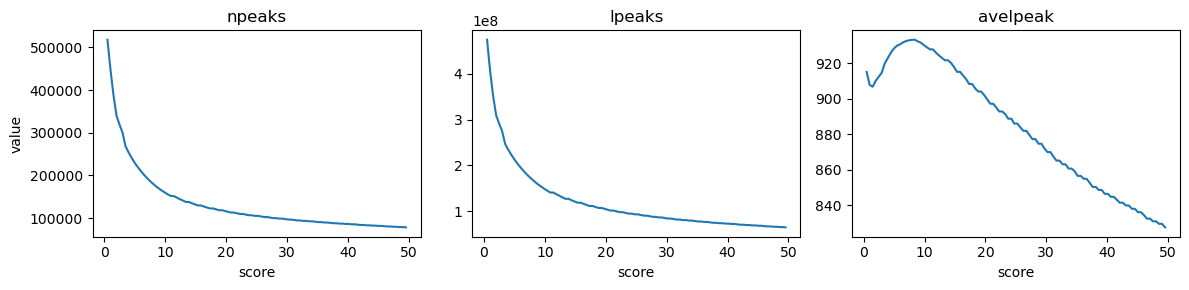

In [15]:
from io import StringIO
import matplotlib.pyplot as plt

cutoff_analysis_df = pd.read_csv(StringIO(cutoff_analysis), sep="\t")
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

axes[0].plot(cutoff_analysis_df["score"], cutoff_analysis_df["npeaks"])
axes[0].set_title("npeaks")
axes[0].set_xlabel("score")
axes[0].set_ylabel("value")

axes[1].plot(cutoff_analysis_df["score"], cutoff_analysis_df["lpeaks"])
axes[1].set_title("lpeaks")
axes[1].set_xlabel("score")

axes[2].plot(cutoff_analysis_df["score"], cutoff_analysis_df["avelpeak"])
axes[2].set_title("avelpeak")
axes[2].set_xlabel("score")

plt.tight_layout()
plt.show()

Then we can call peaks based on these newly generated score track. We will use `q-value`=1e-10 as cutoff, which will be translated into q-score cutoff of 10.

In [16]:
peaks = score_track.call_peaks(cutoff=10)

We can check the number of peaks and the total length of peaks by converting peaks to regions.

In [17]:
# make Regions for peaks from all cell barcodes
regions = Regions()
regions.init_from_PeakIO(peaks)
print(f"Number of peaks: {regions.total}")
print(f"Total basepairs of peaks: {regions.total_length()}")


Number of peaks: 160184
Total basepairs of peaks: 148995908


In [18]:
with open("peaks.narrowPeak","w") as f:
    peaks.write_to_narrowPeak(f)

## Call peaks for the certain cluster of cells

In this section, we will illustrate how to call peaks for a subset of cells from clustering analysis. Assuming that we have clustering results saved in the file 'analysis/clustering/graphclust/clusters.csv'. We downloaded the results from 10X website.

In [19]:
# Read the CSV from clustering analysis
df = pd.read_csv("./analysis/clustering/graphclust/clusters.csv")

# Get barcodes for each cluster
barcodes_cluster_dict = {}
for c in df["Cluster"].unique():
    df_c = df[df["Cluster"] == c]
    barcodes_cluster_dict[c] = set([x.encode() for x in df_c["Barcode"].tolist()])
    print(f"Number of cell barcodes in cluster {c}: {len(barcodes_cluster_dict[c])}")

Number of cell barcodes in cluster 9: 620
Number of cell barcodes in cluster 3: 813
Number of cell barcodes in cluster 1: 1222
Number of cell barcodes in cluster 7: 639
Number of cell barcodes in cluster 6: 658
Number of cell barcodes in cluster 4: 772
Number of cell barcodes in cluster 2: 997
Number of cell barcodes in cluster 5: 770
Number of cell barcodes in cluster 8: 621
Number of cell barcodes in cluster 12: 428
Number of cell barcodes in cluster 13: 379
Number of cell barcodes in cluster 11: 477
Number of cell barcodes in cluster 10: 537
Number of cell barcodes in cluster 14: 269
Number of cell barcodes in cluster 18: 226
Number of cell barcodes in cluster 15: 262
Number of cell barcodes in cluster 19: 102
Number of cell barcodes in cluster 16: 246
Number of cell barcodes in cluster 17: 235


In the following analysis, we will focus on cluster 1 and cluster 10 -- the biggest cluster and the smallest cluster.

In [20]:
# Take subset of fragments for c1
petrack_c1 = petrack.subset(barcodes_cluster_dict[1])

# Take subset of fragments for c10
petrack_c10 = petrack.subset(barcodes_cluster_dict[10])

Let's get some basic stats of the two subsets of fragments.

In [21]:
print(f"Number of fragments for cluster 1: {petrack_c1.total}")
print(f"Number of fragments for cluster 10: {petrack_c10.total}")

Number of fragments for cluster 1: 35551266
Number of fragments for cluster 10: 16631656


Similar to previous steps, we can generate pileup tracks for these two clusters, make the background tracks, calculate scores, and then call peaks with certain cutoff.

### For Cluster 1

Pile up and construct scoreTrack:

In [22]:
# For cluster 1
pileup_track_c1 = petrack_c1.pileup_bdg()
global_bg_track_c1 = pileup_track_c1.set_single_value(pileup_track_c1.summary()[4]) 
score_track_c1 = pileup_track_c1.make_ScoreTrackII_for_macs(global_bg_track_c1, depth1=100, depth2=100)
score_track_c1.change_score_method(ord('q'))

Cutoff analysis:

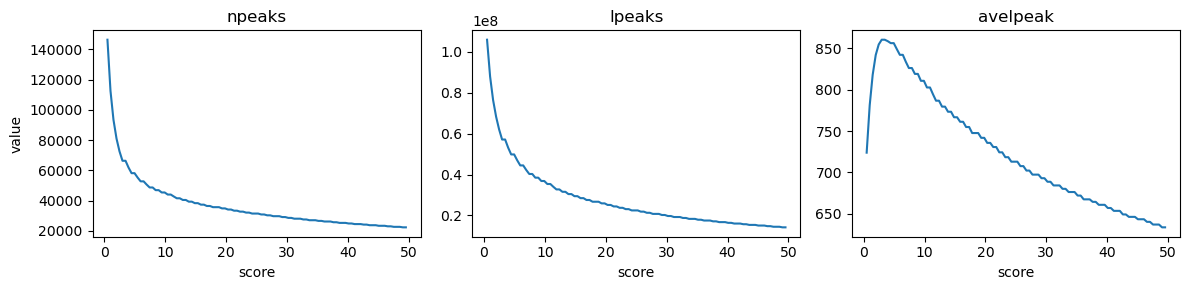

In [23]:
cutoff_analysis_c1 = score_track_c1.cutoff_analysis(min_score=0.5, max_score=50)

cutoff_analysis_df_c1 = pd.read_csv(StringIO(cutoff_analysis_c1), sep="\t")
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

axes[0].plot(cutoff_analysis_df_c1["score"], cutoff_analysis_df_c1["npeaks"])
axes[0].set_title("npeaks")
axes[0].set_xlabel("score")
axes[0].set_ylabel("value")

axes[1].plot(cutoff_analysis_df_c1["score"], cutoff_analysis_df_c1["lpeaks"])
axes[1].set_title("lpeaks")
axes[1].set_xlabel("score")

axes[2].plot(cutoff_analysis_df_c1["score"], cutoff_analysis_df_c1["avelpeak"])
axes[2].set_title("avelpeak")
axes[2].set_xlabel("score")

plt.tight_layout()
plt.show()

According to the analysis, it seems that q-score cutoff of 5 or q-value cutoff of 1e-5 works as a good cutoff.

In [24]:
peaks_c1 = score_track_c1.call_peaks(cutoff=5)

### For Cluster 10

Pile up and construct scoreTrack:

In [25]:
# For cluster 10
pileup_track_c10 = petrack_c10.pileup_bdg()
global_bg_track_c10 = pileup_track_c10.set_single_value(pileup_track_c10.summary()[4]) 
score_track_c10 = pileup_track_c10.make_ScoreTrackII_for_macs(global_bg_track_c10, depth1=100, depth2=100)
score_track_c10.change_score_method(ord('q'))

Cutoff analysis:

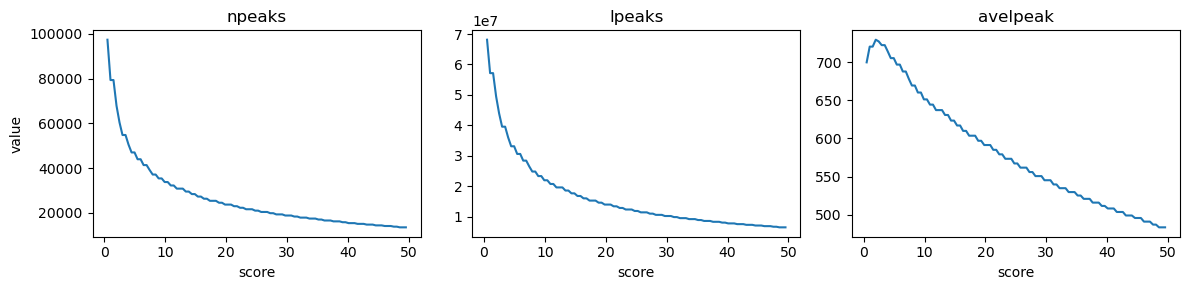

In [26]:
cutoff_analysis_c10 = score_track_c10.cutoff_analysis(min_score=0.5, max_score=50)

cutoff_analysis_df_c10 = pd.read_csv(StringIO(cutoff_analysis_c10), sep="\t")
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

axes[0].plot(cutoff_analysis_df_c10["score"], cutoff_analysis_df_c10["npeaks"])
axes[0].set_title("npeaks")
axes[0].set_xlabel("score")
axes[0].set_ylabel("value")

axes[1].plot(cutoff_analysis_df_c10["score"], cutoff_analysis_df_c10["lpeaks"])
axes[1].set_title("lpeaks")
axes[1].set_xlabel("score")

axes[2].plot(cutoff_analysis_df_c10["score"], cutoff_analysis_df_c10["avelpeak"])
axes[2].set_title("avelpeak")
axes[2].set_xlabel("score")

plt.tight_layout()
plt.show()

According to the analysis, it seems that q-score cutoff of 5 or q-value cutoff of 1e-5 works as a good cutoff.

In [27]:
peaks_c10 = score_track_c10.call_peaks(cutoff=5)

Let's check some basic facts of the peaks called from only the cluster 1 or cluster 10 cell barcodes.

In [28]:
regions_c1 = Regions()
regions_c1.init_from_PeakIO(peaks_c1)
print(f"Number of peaks of cluster 1: {regions_c1.total}")
print(f"Total basepairs of peaks of cluster 1: {regions_c1.total_length()}")

regions_c10 = Regions()
regions_c10.init_from_PeakIO(peaks_c10)
print(f"Number of peaks of cluster 10: {regions_c10.total}")
print(f"Total basepairs of peaks of cluster 10: {regions_c10.total_length()}")

Number of peaks of cluster 1: 58181
Total basepairs of peaks of cluster 1: 49831137
Number of peaks of cluster 10: 47014
Total basepairs of peaks of cluster 10: 33164205


In [29]:
with open("peaks_c1.narrowPeak","w") as f:
    peaks_c1.write_to_narrowPeak(f)

with open("peaks_c10.narrowPeak","w") as f:
    peaks_c10.write_to_narrowPeak(f)

## Compare cluster-specific peaks

We can try to compare these two sets of peaks using functions provided by `Regions` class. Such as get the overlapping regions...

In [30]:
overlapped_regions_c1_c10 = regions_c1.intersect(regions_c10)

print(f"Number of overlapping regions: {overlapped_regions_c1_c10.total}")
print(f"And total basepairs of overlapping regions: {overlapped_regions_c1_c10.total_length()}")

Number of overlapping regions: 33346
And total basepairs of overlapping regions: 24774596


Or unique regions/peaks of cluster 10 that can not be found in the peaks called from cluster 1.

In [31]:
# make Regions for c10 peaks again since later we will alter this object with .exclude function
unique_regions_c10_vs_c1 = Regions()
unique_regions_c10_vs_c1.init_from_PeakIO(peaks_c10)
# then
unique_regions_c10_vs_c1.exclude(regions_c1)

In [32]:
print(f"Peaks of cluster 10 - cluster 1: {unique_regions_c10_vs_c1.total}")
print(f"And total basepairs in peaks of cluster 10 - cluster 1: {unique_regions_c10_vs_c1.total_length()}")

Peaks of cluster 10 - cluster 1: 14142
And total basepairs in peaks of cluster 10 - cluster 1: 6856422


In [33]:
with open("peaks_c10_vs_c1.bed","w") as f:
    unique_regions_c10_vs_c1.write_to_bed(f)

## Missed rare cluster-specific peaks

Some rare cluster-specific peaks may be missing while we call peaks using all cell barcodes. Therefore, we can compare the cluster-specific peaks with the peaks called from all barcodes.

In [34]:
# make Regions for c10 peaks again since later we will alter this object with .exclude function
unique_regions_c10 = Regions()
unique_regions_c10.init_from_PeakIO(peaks_c10)
# then
unique_regions_c10.exclude(regions)

Yes. We do identify rare peaks for cluster 10.

In [35]:
print(f"Number of rare peaks in cluster 10: {unique_regions_c10.total}")

Number of rare peaks in cluster 10: 2064


In [36]:
with open("unique_peaks_c10.bed","w") as f:
    unique_regions_c10.write_to_bed(f)